In [424]:
import networkx as nx
import pyro.distributions as dist
import matplotlib.pylab as plt
import numpy as np
import sys
sys.path.append("/home/folzd/phd/compositions_mixtures_factors")
from model_operators import *
from utils import *
from code_generation import *
from graph_grammar import *
from models_and_guides import *

In [425]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [426]:
factor = nx.DiGraph()

In [427]:
nodes = [
    ('z_loc',{'type':'const', 'value':0.}),
    ('z_scale',{'type':'const', 'value':1.}),
    ('z',{'distribution':dist.Normal,'type':'latent'}),
    #('z_T',{'type':'deterministic', 'function':torch.transpose, 'args':(Num(0),Num(1))}),
    ('z_T',{'type':'function', 'function':torch.transpose, 'args':(Num(0),Num(1))}),
    ('cov_diag_loc',{'type':'param','shape':'D'}),
    ('cov_diag_scale',{'type':'param','shape':'D','constraint':'positive'}),
    ('cov_factor_loc',{'type':'param','shape':'KD'}),
    ('cov_factor_scale',{'type':'param','shape':'KD','constraint':'positive'}),
    ('cov_factor',{'distribution':dist.Normal,'type':'latent'}),
    #('Wz',{'type':'deterministic', 'function':torch.matmul}),
    ('Wz',{'type':'function', 'function':torch.matmul}),
    ('X',{'distribution':dist.MultivariateNormal,'type':'obs'}),
    ('cov_diag',{'distribution':dist.LogNormal,'type':'latent'}),
    #('diag',{'type':'deterministic', 'function':torch.diag_embed}),
    ('diag',{'type':'function', 'function':torch.diag_embed}),
]

In [428]:
edges = [
    ('cov_diag_loc','cov_diag',{'type':'param','param':'loc'}),
    ('cov_diag_scale','cov_diag',{'type':'param','param':'scale'}),
    ('cov_factor_loc','cov_factor',{'type':'param','param':'loc'}),
    ('cov_factor_scale','cov_factor',{'type':'param','param':'scale'}),
    ('z_loc','z',{'type':'param','param':'loc'}),
    ('z_scale','z',{'type':'param','param':'scale'}),    
    #('z','Wz',{'type':'arg', 'transpose':True}),
    ('z','z_T',{'type':'arg'}),
    ('z_T','Wz',{'type':'arg'}),
    ('cov_factor','Wz',{'type':'arg'}),
    ('Wz','X',{'type':'param','param':'loc'}),
    #('cov_diag','X',{'type':'param','param':'scale'})
    ('cov_diag','diag',{'type':'arg'}),
    ('diag','X',{'type':'param','param':'covariance_matrix'})
]

In [429]:
plate_attr = {
    'cov_factor':{'plates':['D','K']},
    'cov_diag':{'plates':['D']},
    'X':{'plates':['N']},
    'Wz':{'plates':['N']},
    'z':{'plates':['N','K']},
    'z_T':{'plates':['N']}
}

In [430]:
factor.add_nodes_from(nodes)
factor.add_edges_from(edges)
nx.set_node_attributes(factor, plate_attr)

W: D, K

z: K, N

Sigma: D

Wz: N

X: N

In [431]:
nx.get_node_attributes(factor, 'plates')

{'z': ['N', 'K'],
 'z_T': ['N'],
 'cov_factor': ['D', 'K'],
 'Wz': ['N'],
 'X': ['N'],
 'cov_diag': ['D']}

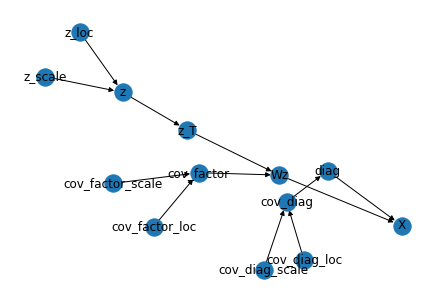

In [432]:
nx.draw(factor, with_labels=True)

In [433]:
list(nx.topological_sort(factor))

['cov_factor_scale',
 'cov_factor_loc',
 'cov_factor',
 'cov_diag_scale',
 'cov_diag_loc',
 'cov_diag',
 'diag',
 'z_scale',
 'z_loc',
 'z',
 'z_T',
 'Wz',
 'X']

In [434]:
plate_graph = make_plate_graph(factor)

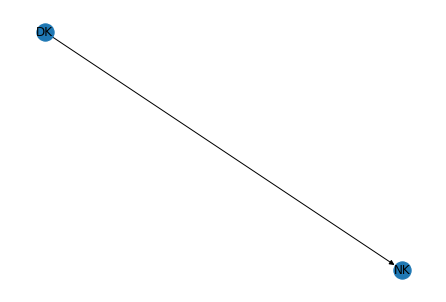

In [435]:
nx.draw(plate_graph, with_labels=True)

In [436]:
generate_Model_class(factor)

In [437]:
pyro.clear_param_store()

In [438]:
from model import DAGModel

In [439]:
N = 1000
D = 10
K = 4

In [440]:
dagmodel = DAGModel(torch.zeros(N,D),K,N,'id')

In [441]:
dagmodel.batch_size = N

In [442]:
tmp = dagmodel.model(torch.zeros(N,D))

In [443]:
tmp.shape

torch.Size([1000, 10])

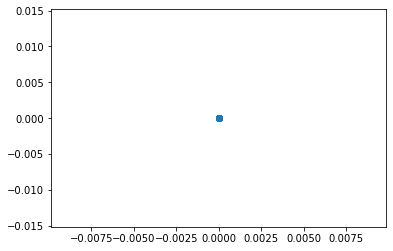

In [444]:
plt.scatter(*tmp[:,:2].detach().T)

In [445]:
foo = dagmodel.unconditioned_model(torch.zeros(N,D))

In [446]:
pyro.clear_param_store()

In [447]:
pyro.set_rng_seed(42)

zeroMeanFactor_teacher = ZeroMeanFactor(torch.empty(N,D), K, N, '0')

dgp = zeroMeanFactor_teacher.unconditioned_model
trace = pyro.poutine.trace(dgp).get_trace(torch.empty(N,D))
true_variables = dict([(name,trace.nodes[name]["value"]) for name in trace.stochastic_nodes if len(name)>1])
X = true_variables['obs'].detach()

data, test_data = train_test_split(X)

In [448]:
data.shape

torch.Size([900, 10])

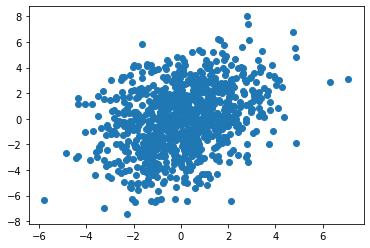

In [449]:
plt.scatter(*data[:,:2].T)

In [450]:
from inference import *

In [451]:
config = dict(
        n_iter = 10000,
        learning_rate = 0.01, 
        beta1 = 0.9,
        beta2 = 0.999,
        learning_rate_decay = 1., # no decay by default
        batch_size = 32, 
        n_elbo_particles = 1, 
        n_posterior_samples = 1024,
        window = 500,
        convergence_window = 30,
        slope_significance = 0.1,
        track_params = False,
        monitor_gradients = False,
        telemetry = None
    )

In [452]:
telemetry = inference(dagmodel, data, test_data, config=config)



NLL after 0/10000 iterations is 33.8366813659668
.......................................................................................................................................................................................................................................................................................\Interrupted by user after 279 iterations.



In [31]:
dagmodel.sample_posterior_predictive(N)

In [32]:
foo = dagmodel.posterior_predictive(data)

In [453]:
foo['cov_factor_id'].shape

IndexError: too many indices for tensor of dimension 2

In [454]:
foo['cov_diag_id'].shape

IndexError: too many indices for tensor of dimension 2

In [455]:
foo['obs'].shape

IndexError: too many indices for tensor of dimension 2

In [456]:
foo['z_id'].shape

IndexError: too many indices for tensor of dimension 2

IndexError: too many indices for tensor of dimension 2

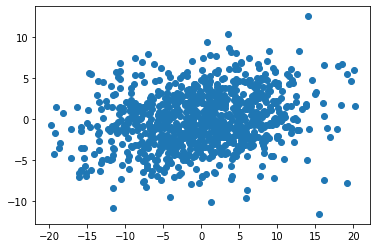

In [457]:
rand_idx = np.random.choice(10,2, replace=False)

rand_idx

plt.scatter(*data[:,rand_idx].T)
plt.scatter(*foo['obs'][:,0,0,rand_idx].squeeze().T.detach())

In [ ]:
plt.plot(telemetry['loss'])

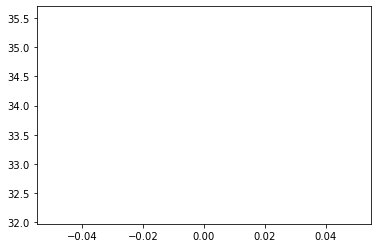

In [458]:
plt.plot(telemetry['MNLL'])

In [459]:
marg_factor = marginalize_factor(factor)

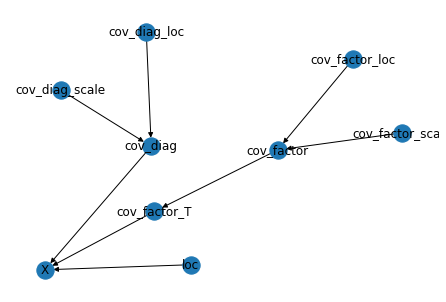

In [460]:
nx.draw(marg_factor, with_labels=True)

In [461]:
from models_and_guides import *

In [462]:
nx.get_node_attributes(marg_factor,'plates')

{'cov_factor': ['D', 'K'], 'X': ['N'], 'cov_diag': ['D']}

In [43]:
generate_Model_class(marg_factor)

In [44]:
from model import DAGModel

pyro.clear_param_store()
dagmodel = DAGModel(torch.zeros(N,D),K,N,'id')
tmp = dagmodel.model(torch.zeros(N,D))

In [45]:
config = dict(
        n_iter = 10000,
        learning_rate = 0.01, 
        beta1 = 0.9,
        beta2 = 0.999,
        learning_rate_decay = 1., # no decay by default
        batch_size = 32, 
        n_elbo_particles = 1, 
        n_posterior_samples = 1024,
        window = 500,
        convergence_window = 30,
        slope_significance = 0.1,
        track_params = False,
        monitor_gradients = False,
        telemetry = None
    )

In [46]:
telemetry = inference(dagmodel, data, test_data, config=config)



NLL after 0/10000 iterations is 29.62999725341797
....................................................................................................................................................................................................................................................................................................................................................................................................................................\Interrupted by user after 420 iterations.



In [ ]:
dagmodel.sample_posterior_predictive(N)

foo = dagmodel.posterior_predictive(data)

foo['obs'].shape

In [47]:
plt.plot(telemetry['loss'])

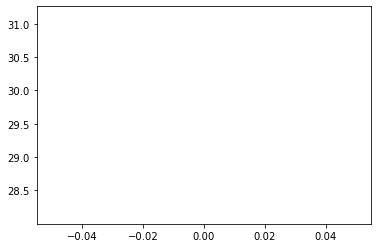

In [51]:
plt.plot(telemetry['MNLL'])

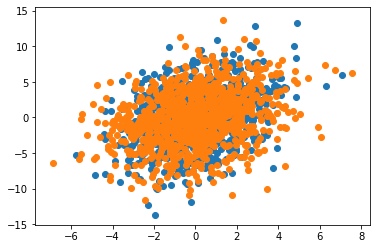

In [52]:
rand_idx = np.random.choice(10,2, replace=False)

rand_idx

plt.scatter(*data[:,rand_idx].T)
plt.scatter(*foo['obs'][:,0,0,rand_idx].squeeze().T.detach())

In [463]:
marg_factor

In [470]:
list(marg_factor.predecessors('X'))

['cov_factor_T', 'cov_diag', 'loc']

In [513]:
mixture = mixture_from_marg_factor(marg_factor)

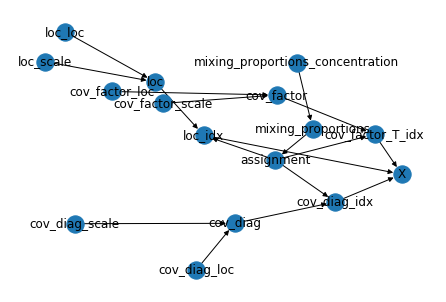

In [514]:
nx.draw(mixture, with_labels=True)

In [515]:
nx.get_node_attributes(mixture, 'plates')

{'cov_diag_loc': ['C'],
 'cov_diag_scale': ['C'],
 'cov_factor_loc': ['C'],
 'cov_factor_scale': ['C'],
 'cov_factor': ['C', 'D', 'K'],
 'X': ['N'],
 'cov_diag': ['C', 'D'],
 'loc': ['C'],
 'assignment': ['N'],
 'cov_diag_idx': ['N'],
 'loc_idx': ['N'],
 'cov_factor_T_idx': ['N']}

In [516]:
nx.get_node_attributes(mixture, 'shape')

{'cov_diag_loc': 'DC',
 'cov_diag_scale': 'DC',
 'cov_factor_loc': 'KDC',
 'cov_factor_scale': 'KDC',
 'mixing_proportions_concentration': 'C',
 'loc_loc': 'DC',
 'loc_scale': 'DC'}

In [517]:
plate = ''.join(mixture.nodes['cov_factor']['plates'])

In [518]:
#generate_Model_class(marg_factor)
generate_Model_class(mixture)

In [519]:
from model import DAGModel

In [520]:
pyro.clear_param_store()
C = 5
dagmodel = DAGModel(torch.zeros(N,D),C,K,N,'id')
tmp = dagmodel.model(torch.zeros(N,D))

In [521]:
dagmodel.param_shapes_and_support

{'loc_scale_init_id': ((10, 5), GreaterThan(lower_bound=0.0)),
 'loc_prior_scale_init_id': ((10, 5), GreaterThan(lower_bound=0.0)),
 'loc_loc_init_id': ((10, 5), Real()),
 'loc_prior_loc_init_id': ((10, 5), Real()),
 'mixing_proportions_concentration_init_id': ((5,),
  GreaterThan(lower_bound=0.0)),
 'mixing_proportions_prior_concentration_init_id': ((5,),
  GreaterThan(lower_bound=0.0)),
 'cov_factor_scale_init_id': ((4, 10, 5), GreaterThan(lower_bound=0.0)),
 'cov_factor_prior_scale_init_id': ((4, 10, 5), GreaterThan(lower_bound=0.0)),
 'cov_factor_loc_init_id': ((4, 10, 5), Real()),
 'cov_factor_prior_loc_init_id': ((4, 10, 5), Real()),
 'cov_diag_scale_init_id': ((10, 5), GreaterThan(lower_bound=0.0)),
 'cov_diag_prior_scale_init_id': ((10, 5), GreaterThan(lower_bound=0.0)),
 'cov_diag_loc_init_id': ((10, 5), Real()),
 'cov_diag_prior_loc_init_id': ((10, 5), Real())}

In [522]:
dgp = dagmodel.unconditioned_model
trace = pyro.poutine.trace(dgp).get_trace(torch.empty(N,D))
true_variables = dict([(name,trace.nodes[name]["value"]) for name in trace.stochastic_nodes if len(name)>1])
X = true_variables['obs'].detach()
data, test_data = train_test_split(X)
train_assign, test_assign = train_test_split(true_variables['assignment_id'].detach().unsqueeze(-1))

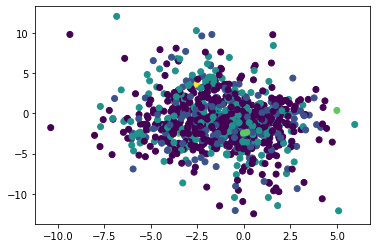

In [523]:
rand_idx = np.random.choice(10,2, replace=False)

rand_idx

plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
#plt.scatter(*foo['obs'][:,0,0,rand_idx].squeeze().T.detach())

In [524]:
config = dict(
        n_iter = 10000,
        learning_rate = 0.01, 
        beta1 = 0.9,
        beta2 = 0.999,
        learning_rate_decay = 1., # no decay by default
        batch_size = 32, 
        n_elbo_particles = 1, 
        n_posterior_samples = 1024,
        window = 500,
        convergence_window = 30,
        slope_significance = 0.1,
        track_params = False,
        monitor_gradients = False,
        telemetry = None
    )

In [525]:
telemetry = inference(dagmodel, data, test_data, config=config)



NLL after 0/10000 iterations is 26.50572967529297
...................................................................................................................................................................................................................................................................................................\Interrupted by user after 291 iterations.



In [526]:
dagmodel.sample_posterior_predictive(N)

ValueError: cov_factor must be a batch of matrices with shape 1 x m
                            Trace Shapes:            
                             Param Sites:            
                       loc_prior_scale_id      10 5  
                         loc_prior_loc_id      10 5  
                cov_factor_prior_scale_id    4 10 5  
                  cov_factor_prior_loc_id    4 10 5  
                  cov_diag_prior_scale_id      10 5  
                    cov_diag_prior_loc_id      10 5  
mixing_proportions_prior_concentration_id         5  
                            Sample Sites:            
                                C_id dist         |  
                                    value       5 |  
                              loc_id dist   10  5 |  
                                    value 1 10  5 |  
                               CD_id dist         |  
                                    value      10 |  
                              CDK_id dist         |  
                                    value       4 |  
                       cov_factor_id dist 4 10  5 |  
                                    value 4 10  5 |  
                         cov_diag_id dist   10  5 |  
                                    value 1 10  5 |  
               mixing_proportions_id dist         | 5
                                    value 1  1  1 | 5
                                N_id dist         |  
                                    value       1 |  
                       assignment_id dist 1  1  1 |  
                                    value 1  1  1 |  

In [404]:
foo = dagmodel.posterior_predictive(data)

foo['obs'].shape

torch.Size([1000, 1, 1, 32, 10])

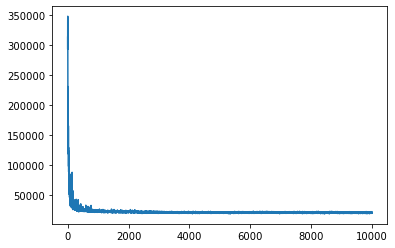

In [405]:
plt.plot(telemetry['loss'])

In [407]:
foo['obs'].shape

torch.Size([1000, 1, 1, 32, 10])

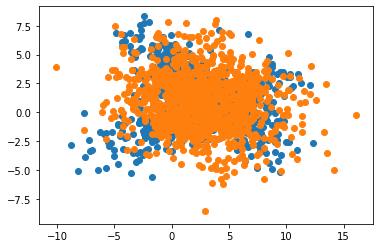

In [422]:
plt.scatter(*data[:,rand_idx].T)
plt.scatter(*foo['obs'][:,0,0,0,rand_idx].squeeze().T.detach())